In [1]:
import ot
import sgw
import scanpy as sc
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [2]:
def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])

In [3]:
def plot_mapping_color(P,X_1,X_2,c1,c2, thresh=None, linewidth=1, s = 1):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c=c1, vmin=0, vmax=1, s=s)
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c=c2, vmin=0, vmax=1, s=s)
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])

In [4]:
def obs_to_colors(obs_names, cmap):
    colors = []
    for obs_name in obs_names:
        colors.append(cmap[obs_name])
    return colors

In [5]:
def connected_knn_graph(X, k=5):
    D = distance_matrix(X,X)
    n = D.shape[0]
    A = np.zeros([n,n])
    for i in range(n):
        idx = np.argsort(D[i,:])
        A[i,idx[1:1+k]] = 1
    A = A + A.T
    A[np.where(A>0)] = 1
    G = nx.from_numpy_array(A)
    cc = list( nx.connected_components(G) )
    while len(cc)>1:
        for c in cc:
            c = list(c)
            c_complement = np.array( [i for i in range(n) if not i in c] )
            c = np.array(c)
            DD = D[c,:][:,c_complement]
            i,j = np.where(DD==DD.min())
            G.add_edge(c[i[0]],c_complement[j[0]])
        cc = list( nx.connected_components(G) )
    AA = nx.to_numpy_array(G)
    DD = D * AA
    return AA, DD

## **Basic processing**

In [6]:
adata = sc.datasets.paul15()

In [7]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [8]:
sc.pp.recipe_zheng17(adata)

In [9]:
sc.tl.pca(adata, svd_solver='arpack')

In [10]:
adata

AnnData object with n_obs × n_vars = 2730 × 999
    obs: 'paul15_clusters', 'n_counts_all'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)

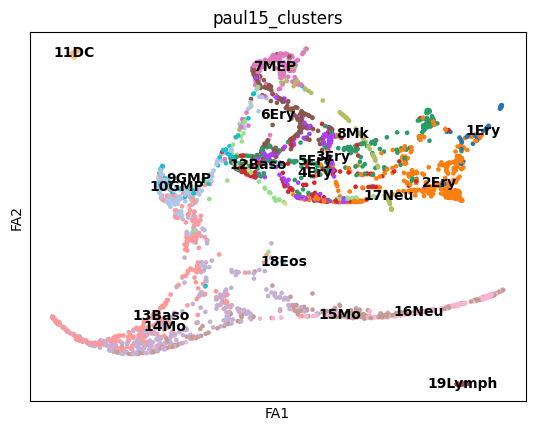

In [12]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

In [13]:
sc.tl.leiden(adata, resolution=1.0)

In [14]:
sc.tl.paga(adata, groups='leiden')

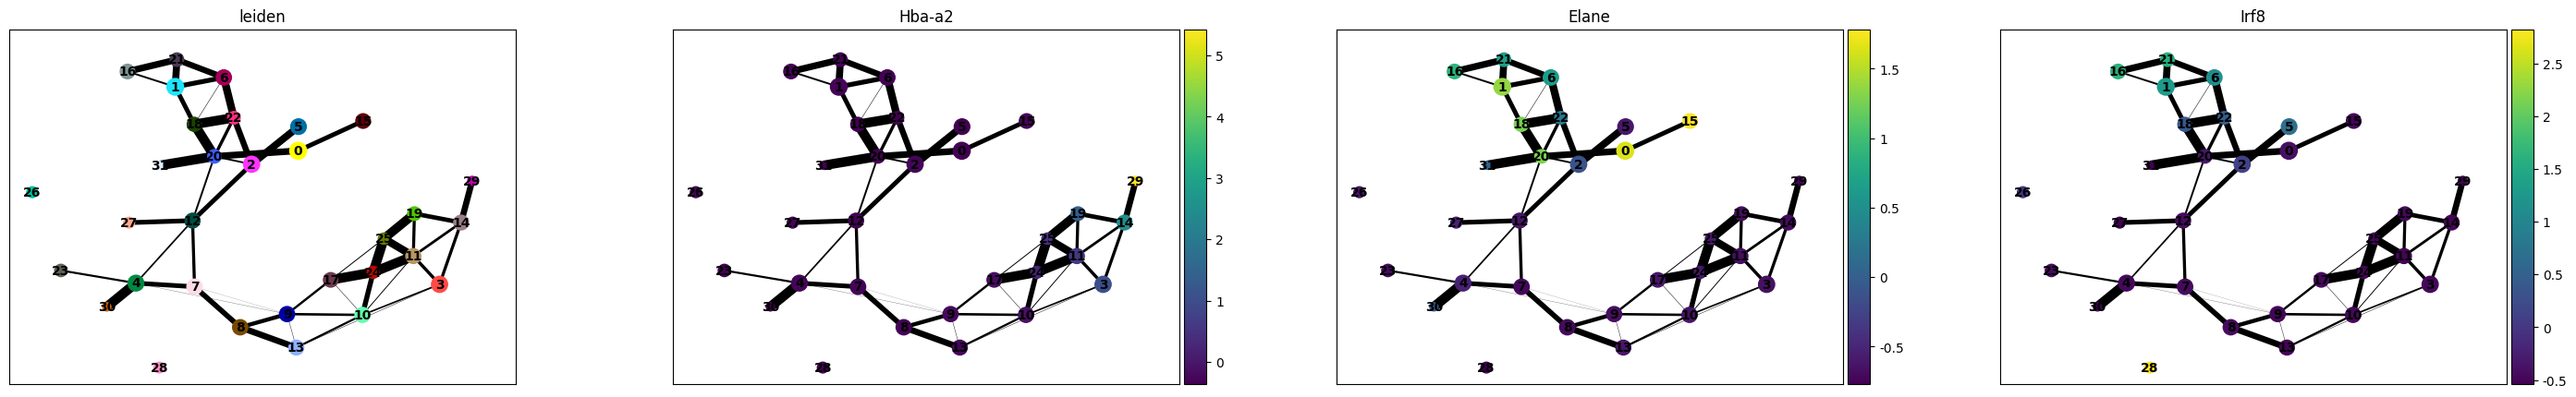

In [15]:
sc.pl.paga(adata, color=['leiden', 'Hba-a2', 'Elane', 'Irf8'])

In [16]:
sc.tl.paga(adata, groups='leiden')

<Axes: >

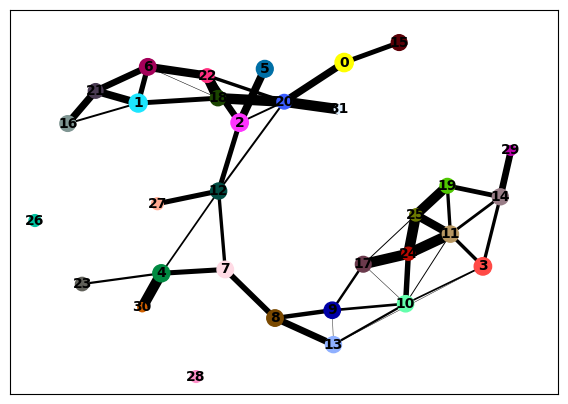

In [17]:
sc.pl.paga(adata, threshold=0.03, show=False)

In [18]:
sc.tl.draw_graph(adata, init_pos='paga')

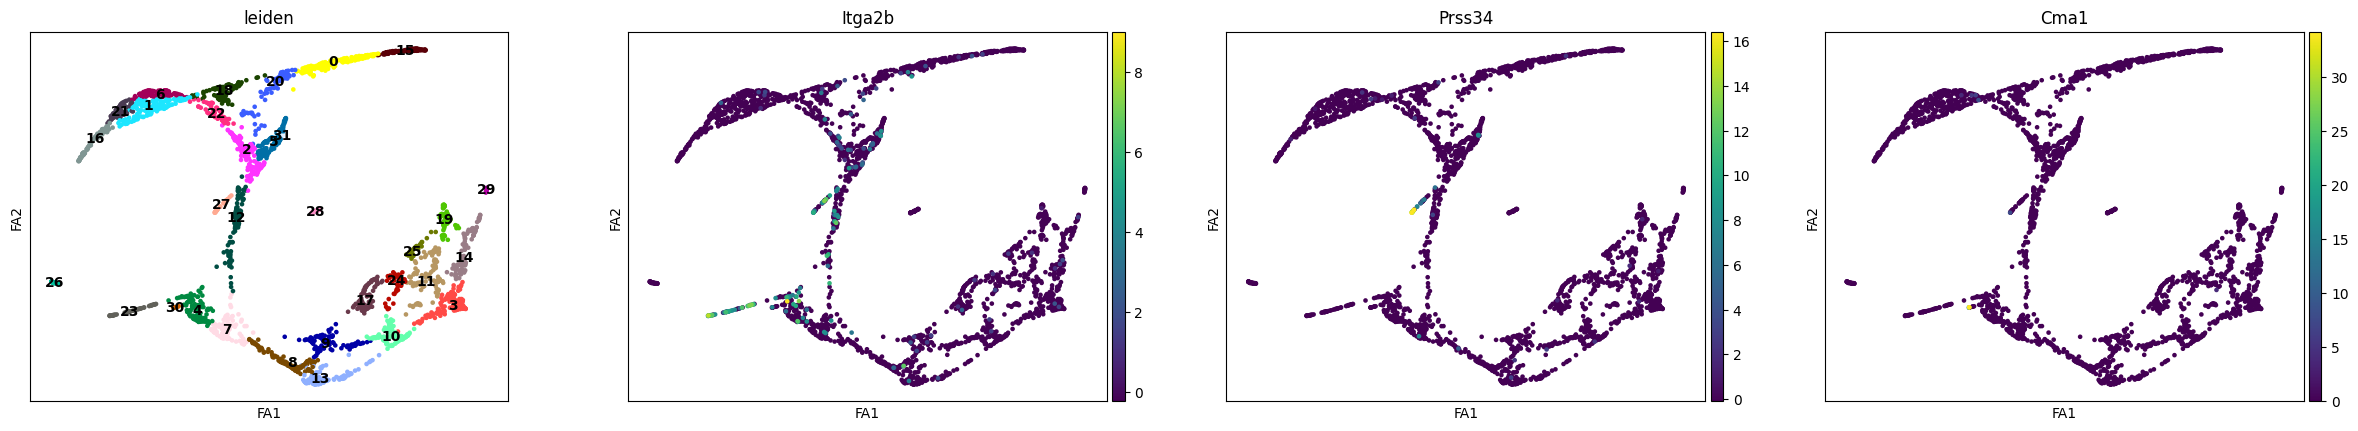

In [19]:
sc.pl.draw_graph(adata, color=['leiden', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

In [20]:
sc.tl.dpt(adata)

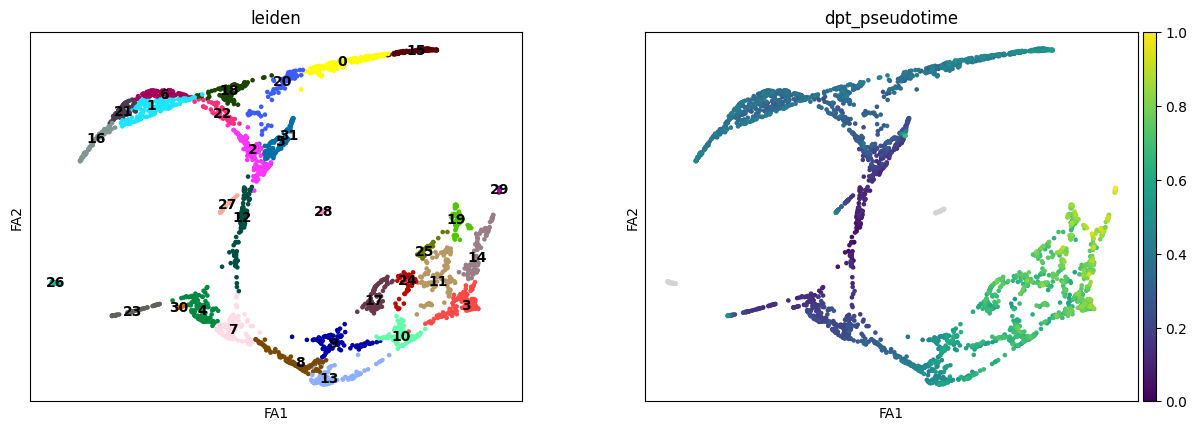

In [21]:
sc.pl.draw_graph(adata, color=['leiden', 'dpt_pseudotime'], legend_loc='on data')

In [22]:
import plotly
discrete_colors = plotly.colors.qualitative.Light24
print(len(discrete_colors))
print(len(set(adata.obs['paul15_clusters'])))
cmap_paul = {}
cell_type_names = np.sort(list(set(adata.obs['paul15_clusters'])))
for i in range(len(cell_type_names)):
    cmap_paul[cell_type_names[i]] = discrete_colors[i]

24
19


### **Subsetting based on diffusion pseudotime**

In [68]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=10)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_diffmap')
adata_1_tmp = adata.copy()
adata_2_tmp = adata.copy()
sc.tl.umap(adata_1_tmp, n_components=2, random_state=547)
sc.tl.umap(adata_2_tmp, n_components=2, random_state=12345)


_,A = connected_knn_graph(adata_1_tmp.obsm['X_umap'], k=3)
G = nx.from_numpy_array(A)
ncell = A.shape[0]
p = dict(nx.shortest_path_length(G, weight='weight'))
D = np.array([[p[i][j] for i in range(ncell)] for j in range(ncell)])
adata_1_tmp.obsp['geodesics'] = D

_,A = connected_knn_graph(adata_2_tmp.obsm['X_umap'], k=3)
G = nx.from_numpy_array(A)
ncell = A.shape[0]
p = dict(nx.shortest_path_length(G, weight='weight'))
D = np.array([[p[i][j] for i in range(ncell)] for j in range(ncell)])
adata_2_tmp.obsp['geodesics'] = D

downsample_idx = sgw.downsample_data(adata_1_tmp.obsm['X_umap'], method='mapper', km_n_cubes=12, km_perc_overlap=0.2)

adata_1_ds_tmp = adata_1_tmp[downsample_idx,:]
adata_2_ds_tmp = adata_2_tmp[downsample_idx,:]

idx_1 = np.where(adata.obs['dpt_pseudotime']<=0.8)[0]
adata_1 = adata_1_tmp[idx_1,:].copy()
idx_2 = np.where(adata.obs['dpt_pseudotime']>=0.1)[0]
adata_2 = adata_2_tmp[idx_2,:].copy()
print(adata.shape, adata_1.shape, adata_2.shape)
idx_1 = np.where(adata_1_ds_tmp.obs['dpt_pseudotime']<=0.8)[0]
adata_1_sub = adata_1_ds_tmp[idx_1,:]
idx_2 = np.where(adata_2_ds_tmp.obs['dpt_pseudotime']>=0.1)[0]
adata_2_sub = adata_2_ds_tmp[idx_2,:]
print(adata_1_ds_tmp.shape, adata_2_ds_tmp.shape, adata_1_sub.shape, adata_2_sub.shape)

(2730, 999) (2541, 999) (2642, 999)
(80, 999) (80, 999) (74, 999) (78, 999)


In [69]:
X_umap_1 = adata_1.obsm['X_umap']
X_umap_2 = adata_2.obsm['X_umap']
plt.scatter(X_umap_1[:,0], X_umap_1[:,1], c=adata_1.obs['dpt_pseudotime'], vmin=0, vmax=1, s=10)
plt.axis('equal')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.savefig("./figures/data1_umap_pseudotime.pdf")
plt.clf()
plt.scatter(X_umap_2[:,0], X_umap_2[:,1], c=adata_2.obs['dpt_pseudotime'], vmin=0, vmax=1, s=10)
plt.axis('equal')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.savefig("./figures/data2_umap_pseudotime.pdf")
plt.clf()

<Figure size 640x480 with 0 Axes>

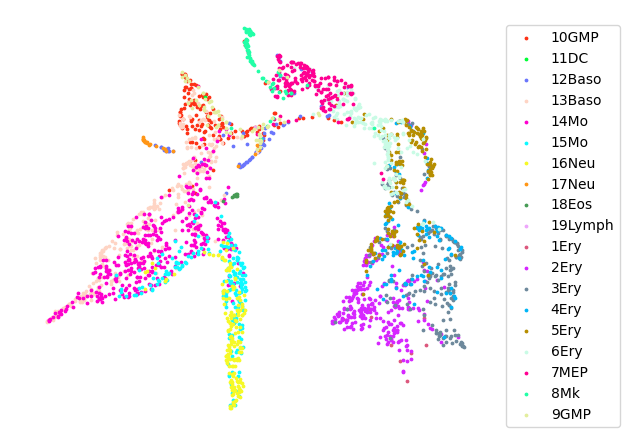

In [70]:
for i in range(len(cell_type_names)):
    idx = np.where(adata_1.obs['paul15_clusters'] == cell_type_names[i])[0]
    plt.scatter(X_umap_1[idx,0], X_umap_1[idx,1], c=discrete_colors[i], label = cell_type_names[i], s=3)
plt.legend(loc=[1.01,0])
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig("./figures/data1_umap_cluster.pdf")

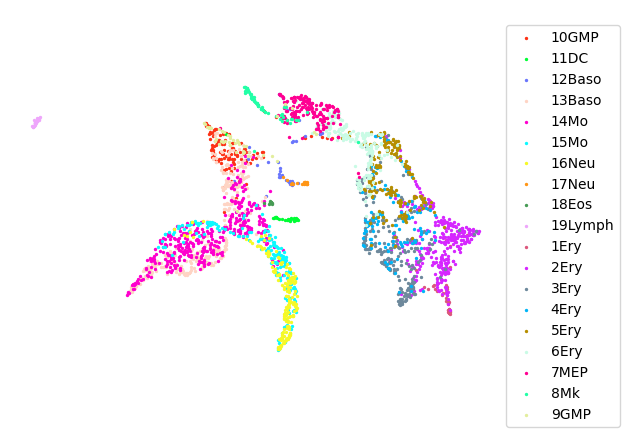

In [71]:
for i in range(len(cell_type_names)):
    idx = np.where(adata_2.obs['paul15_clusters'] == cell_type_names[i])[0]
    plt.scatter(X_umap_2[idx,0], X_umap_2[idx,1], c=discrete_colors[i], label = cell_type_names[i], s=2)
plt.legend(loc=[1.01,0])
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig("./figures/data2_umap_cluster.pdf")

In [72]:
plt.scatter(adata_1.obsm['X_umap'][:,0], adata_1.obsm['X_umap'][:,1], label='full dataset', c='lightgrey', s=7)
plt.scatter(adata_1_sub.obsm['X_umap'][:,0], adata_1_sub.obsm['X_umap'][:,1], label='subsampled dataset', s=10, c='dimgrey')
plt.axis('equal')
plt.axis('off')
plt.savefig("./figures/data1_umap_downsample.pdf")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [73]:
plt.scatter(adata_2.obsm['X_umap'][:,0], adata_2.obsm['X_umap'][:,1], label='full dataset', c='lightgrey', s=7)
plt.scatter(adata_2_sub.obsm['X_umap'][:,0], adata_2_sub.obsm['X_umap'][:,1], label='subsampled dataset', s=10, c='dimgrey')
plt.axis('equal')
plt.axis('off')
plt.savefig("./figures/data2_umap_downsample.pdf")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [74]:
D_1 = adata_1_sub.obsp['geodesics']
D_2 = adata_2_sub.obsp['geodesics']

In [75]:
# D_1 = D_1 / D_1.max() * D_2.max()

In [76]:
P = sgw.supervised_gromov_wasserstein(D_1, D_2, nitermax=20, threshold=1.5)

In [77]:
adata_1_sub

View of AnnData object with n_obs × n_vars = 74 × 999
    obs: 'paul15_clusters', 'n_counts_all', 'leiden', 'dpt_pseudotime'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'draw_graph', 'paul15_clusters_colors', 'leiden', 'paga', 'leiden_sizes', 'leiden_colors', 'umap'
    obsm: 'X_pca', 'X_diffmap', 'X_draw_graph_fa', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'geodesics'

In [78]:
plot_mapping_color(P, adata_1_sub.obsm['X_umap'], adata_2_sub.obsm['X_umap'], adata_1_sub.obs['dpt_pseudotime'], adata_2_sub.obs['dpt_pseudotime'], s = 20, thresh=0.000000000001)
plt.savefig('./figures/coupling_downsample_pseudotime.pdf')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [79]:
DD1 = adata_1.obsp['geodesics'][:,[np.where(adata_1.obs_names==adata_1_sub.obs_names[i])[0][0] for i in range(adata_1_sub.shape[0])]]
DD2 = adata_2.obsp['geodesics'][:,[np.where(adata_2.obs_names==adata_2_sub.obs_names[i])[0][0] for i in range(adata_2_sub.shape[0])]]

In [90]:
P_full = sgw.recover_full_coupling(P,DD1,DD2,delta=0.45, thresh=10, eps=0.01, nitermax=100000)

In [91]:
plot_mapping_color(P_full.toarray(), adata_1.obsm['X_umap'], adata_2.obsm['X_umap'], adata_1.obs['dpt_pseudotime'], adata_2.obs['dpt_pseudotime'], thresh=0.00001, linewidth=0.05)
plt.savefig('./figures/coupling_full_pseudotime.pdf')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [92]:
adata_1

AnnData object with n_obs × n_vars = 2541 × 999
    obs: 'paul15_clusters', 'n_counts_all', 'leiden', 'dpt_pseudotime'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'draw_graph', 'paul15_clusters_colors', 'leiden', 'paga', 'leiden_sizes', 'leiden_colors', 'umap'
    obsm: 'X_pca', 'X_diffmap', 'X_draw_graph_fa', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'geodesics'

In [93]:
adata_1_colors = obs_to_colors(adata_1.obs['paul15_clusters'], cmap_paul)
adata_2_colors = obs_to_colors(adata_2.obs['paul15_clusters'], cmap_paul)

In [94]:
plot_mapping_color(P_full.toarray(), adata_1.obsm['X_umap'], adata_2.obsm['X_umap'], adata_1_colors, adata_2_colors, thresh=0.00001, linewidth=0.05)
plt.savefig('./figures/coupling_full_cluster.pdf')
plt.clf()

<Figure size 640x480 with 0 Axes>